<a href="https://colab.research.google.com/github/gpappetti/famaFrench/blob/main/predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()
# The tech stocks we'll use for this analysis
stock_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


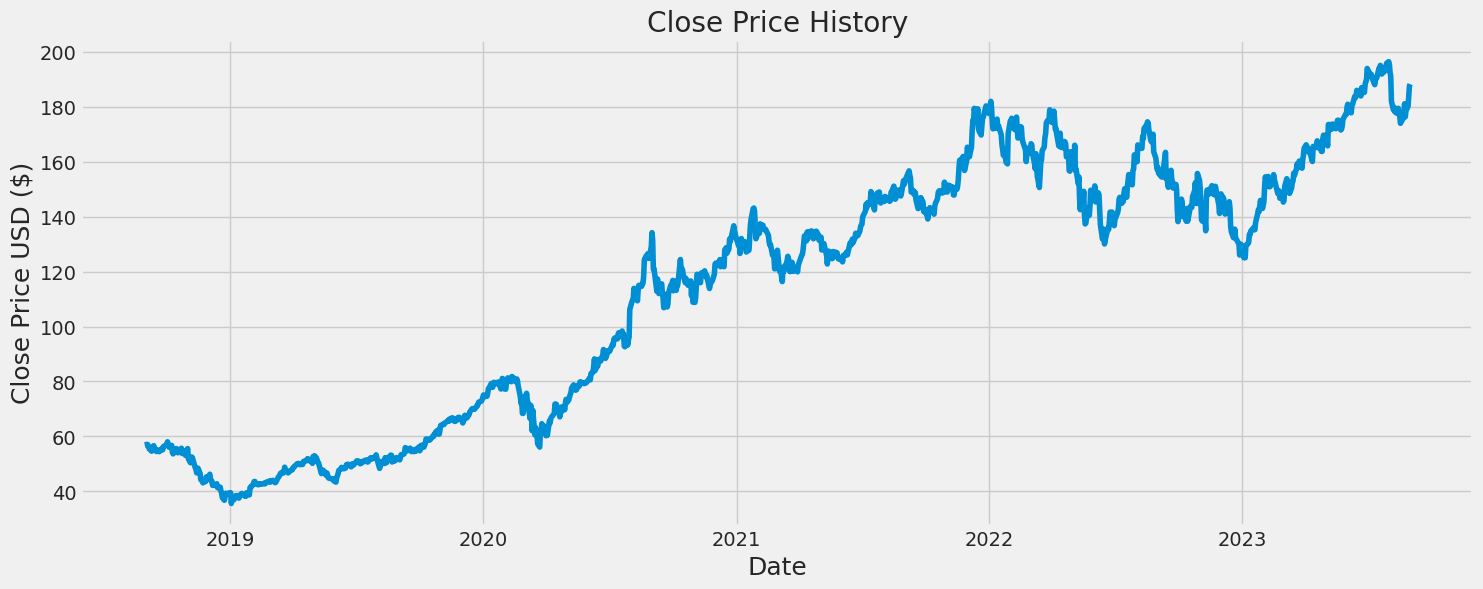

In [5]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(AAPL['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [8]:
# Create a new dataframe with only the 'Close column
data = AAPL.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1196

In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.13275121],
       [0.13388543],
       [0.13157035],
       ...,
       [0.92336973],
       [0.94530847],
       [0.94919718]])

In [10]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.13275121, 0.13388543, 0.13157035, 0.12571278, 0.12291606,
       0.11830146, 0.12687809, 0.1225587 , 0.13085565, 0.12686253,
       0.11760228, 0.11816163, 0.1183636 , 0.1209428 , 0.11726046,
       0.12212363, 0.12429888, 0.12154876, 0.12858718, 0.12981465,
       0.13217631, 0.13531486, 0.1396498 , 0.13331055, 0.12756171,
       0.12675379, 0.13157035, 0.1152406 , 0.11227295, 0.12417458,
       0.11679433, 0.12423672, 0.12274514, 0.11471233, 0.11982411,
       0.12190611, 0.12513789, 0.11326734, 0.12058545, 0.11514738,
       0.10883921, 0.11048617, 0.11912494, 0.12434549, 0.10144341,
       0.09229191, 0.09567907, 0.10528114, 0.1030127 , 0.09676668,
       0.08076319, 0.07774894, 0.06931216, 0.07647489, 0.0797688 ,
       0.06785165, 0.05405446, 0.05374372, 0.04676744, 0.05038765])]
[0.04979724333246782]

[array([0.13275121, 0.13388543, 0.13157035, 0.12571278, 0.12291606,
       0.11830146, 0.12687809, 0.1225587 , 0.13085565, 0.12686253,
       0.11760228, 0.11816163, 0.11

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1136/1136 [==============================] - 54s 44ms/step - loss: 0.0022


In [18]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 120: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(120, len(test_data)):
    x_test.append(test_data[i-120:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 77ms/step


3.8531806803603064

<ipython-input-19-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


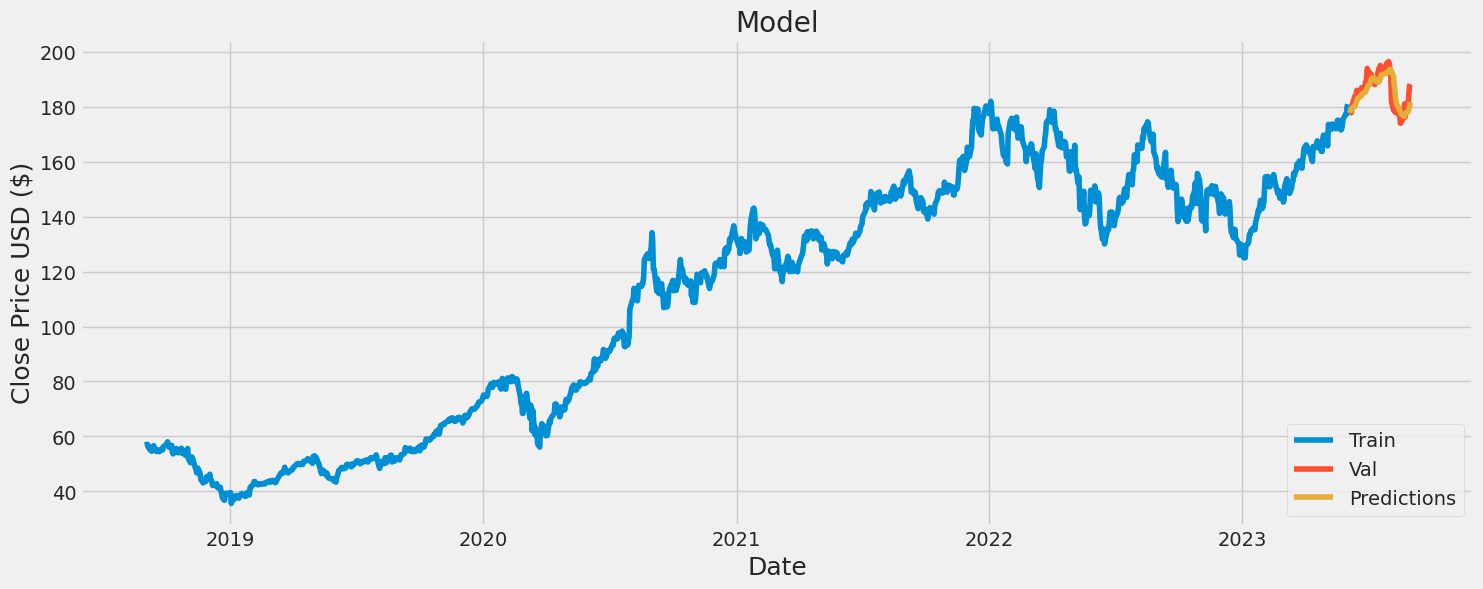

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()